# Evaluating $\overline{\nu}$ and $\overline{N_{\gamma}}$ Convergence for U-235

In [13]:
import numpy as np
import scipy as sp
import os
from statistics import *
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sympy as sym
from sympy.interactive import printing
printing.init_printing(use_latex = 'mathjax')
from IPython.display import display, Math, Latex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
%matplotlib inline

In [14]:
### rcParams are the default parameters for matplotlib
import matplotlib as mpl

print ("Matplotbib Version: ", mpl.__version__)

mpl.rcParams['font.size'] = 18
mpl.rcParams['font.family'] = 'Helvetica', 'serif'
#mpl.rcParams['font.color'] = 'darkred'
mpl.rcParams['font.weight'] = 'normal'

mpl.rcParams['axes.labelsize'] = 18.
mpl.rcParams['xtick.labelsize'] = 18.
mpl.rcParams['ytick.labelsize'] = 18.
mpl.rcParams['lines.linewidth'] = 2.

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'normal',
        'size'   : 18,
        }

mpl.rcParams['xtick.major.pad']='10'
mpl.rcParams['ytick.major.pad']='10'

mpl.rcParams['image.cmap'] = 'inferno'

Matplotbib Version:  2.0.2


In [15]:
filepath = os.path.join(os.getcwd(), 'U235ConvergenceFiles')
if not os.path.isdir(filepath):
    raise ValueError('You do not have the directory "ConvergenceFiles" in your current working directory')

print(os.listdir(filepath))

nnt_mean = []
nn2t_mean = []
nn3t_mean = []
ngt_mean = []
ng2t_mean = []
ng3t_mean = []
TKE_mean = []
Enlab_mean = []
Eglab_mean = []
nhist_arr   = []

for filename in os.listdir(filepath):
    
    test_i = filename.index('test')

    n_histories = int(filename[test_i+4:])*10
    nhist_arr.append(n_histories)

    file_loc = os.path.join(filepath,filename)
    working_file = open(file_loc)
    
    # read first line -----------------------------------------------------------------------------------------------
    line = working_file.readline()
    if (line.find("#")!=0):
        sys.exit("ERROR: FIRST LINE OF OUTPUT FILE SHOULD CONTAIN '#'")
        
    # read remainder -----------------------------------------------------------------------------------------------
    nfragments = 0
    
    # re-initialize all arrays
    # Line 1 Arrays of interest

#     Ul, Uh, TXE      = [], [], []
#     Jl, Jh, J        = [], [], []
    KEl, KEh, TKE    = [], [], []
    nnl, nnh, nnt    = [], [], []
    ngl, ngh, ngt    = [], [], []

    # Direction/momentum vectors are arranged with CoM first, then Lab
    # Fragment momentum arrays - Line 2
    #Pcml, Pcmh       = [], []
    #Plabl, Plabh     = [], []
    
    # For now, just save the resulting particle energies
    # Neutron Energies - Line 3
    Encml, Encmh     = [], []
    Enlabl, Enlabh   = [], []
    
    # Gamma Energies - Line 4
    Egcml, Egcmh     = [], []
    Eglabl, Eglabh   = [], []
    
    while True:
        line = working_file.readline()
        if (len(line)==0):
            break
        #LINE ONE OF FISSION EVENT (A, Z, U, J, P, KE, nn, ng, nIC)
        nfragments+=1
        tempdata1 = line.split()
        if (nfragments % 2 == 1): # LIGHT FRAGMENT
#             Ul.append(float(tempdata1[2]))
#             Jl.append(float(tempdata1[3]))
            KEl.append(float(tempdata1[5]))
            nnl.append(int(tempdata1[6]))
            ngl.append(int(tempdata1[7]))

        else: # HEAVY FRAGMENT
#             Uh.append(float(tempdata1[2]))
#             Jh.append(float(tempdata1[3]))
            KEh.append(float(tempdata1[5]))
            nnh.append(int(tempdata1[6]))
            ngh.append(int(tempdata1[7]))

        
        #LINE TWO OF FISSION EVENT (momentum vector in Lab and center of mass of FRAGMENT)
        line = working_file.readline()
        tempdata2 = line.split()
        # for now, don't worry about line 2
        
        #LINE THREE OF FISSION EVENT (Neutron direction cosines and energies, Lab and center of mass respectively)
        if (int(tempdata1[6]) != 0):
            line = working_file.readline()
            tempdata3 = line.split()
            if (nfragments % 2 == 1): # LIGHT FRAGMENT
                for i in range(int(tempdata1[6])):
                    Encml.append(float(tempdata3[4*i + 7]))
                    Enlabl.append(float(tempdata3[8*i + 7]))
            else: # HEAVY FRAGMENT
                for i in range(int(tempdata1[6])):
                    Encmh.append(float(tempdata3[4*i + 7]))
                    Enlabh.append(float(tempdata3[8*i + 7]))
            
        
        #LINE FOUR OF FISSION EVENT (Gamma direction cosines and energies, Lab and center of mass respectively)
        if (int(tempdata1[7]) != 0):
            line = working_file.readline()
            tempdata4 = line.split()
            if (nfragments % 2 == 1): # LIGHT FRAGMENT
                for i in range(int(tempdata1[7])):
                    Egcml.append(float(tempdata4[4*i + 7]))
                    Eglabl.append(float(tempdata4[8*i + 7]))
            else: # HEAVY FRAGMENT
                for i in range(int(tempdata1[7])):
                    Egcmh.append(float(tempdata4[4*i + 7]))
                    Eglabh.append(float(tempdata4[8*i + 7]))
        
#         if (nfragments>=MaxHistories*2):
#             break
#     nhistories = nfragments/2
    
    # Concatenate arrays
#     TXE    = np.sum([Ul , Uh], axis=0)
#     J      = Jl + Jh
    TKE    = np.sum([KEl , KEh], axis=0)
    nnt    = np.sum([nnl , nnh], axis=0)
    nn2t   = [float(nnt[i] * (nnt[i]-1)) for i in range(len(nnt))] # 2nd factorial moment
    nn3t   = [float(nnt[i] * (nnt[i]-1) * (nnt[i]-2)) for i in range(len(nnt))] # 3rd factorial moment
    ngt    = np.sum([ngl , ngh], axis=0)
    ng2t   = [float(ngt[i] * (ngt[i]-1)) for i in range(len(ngt))]
    ng3t   = [float(ngt[i] * (ngt[i]-1) * (ngt[i]-2)) for i in range(len(ngt))]
    Encm  = Encml + Encmh
    Egcm  = Egcml + Egcmh
    Enlab = Enlabl + Enlabh
    Eglab = Eglabl + Eglabh
    
    # Close File that is read
    working_file.close()
    
    print(n_histories)
    print(mean(nnt.astype(float)))
    
    nnt_mean.append(mean(nnt.astype(float)))
    ngt_mean.append(mean(ngt.astype(float)))
    TKE_mean.append(mean(TKE.astype(float)))
    Enlab_mean.append(mean(Enlab))
    Eglab_mean.append(mean(Eglab))
    nn2t_mean.append(mean(nn2t))
    nn3t_mean.append(mean(nn3t))
    ng2t_mean.append(mean(ng2t))
    ng3t_mean.append(mean(ng3t))


['histories-vectors.CGMF.test267', 'histories-vectors.CGMF.test26', 'histories-vectors.CGMF.test2800', 'histories-vectors.CGMF.test1021', 'histories-vectors.CGMF.test19', 'histories-vectors.CGMF.test10', 'histories-vectors.CGMF.test3919', 'histories-vectors.CGMF.test730', 'histories-vectors.CGMF.test50', 'histories-vectors.CGMF.test5486', 'histories-vectors.CGMF.test1429', 'histories-vectors.CGMF.test522', 'histories-vectors.CGMF.test137', 'histories-vectors.CGMF.test191', 'histories-vectors.CGMF.test7680', 'histories-vectors.CGMF.test373', 'histories-vectors.CGMF.test70', 'histories-vectors.CGMF.test14', 'histories-vectors.CGMF.test10752', 'histories-vectors.CGMF.test36', 'histories-vectors.CGMF.test2000', 'histories-vectors.CGMF.test98']
2670
2.48801498127
260
2.40769230769
28000
2.49432142857
10210
2.44897159647
190
2.60526315789
100
2.54
39190
2.46611380454
7300
2.46794520548
500
2.498
54860
2.4816441852
14290
2.46081175647
5220
2.4745210728
1370
2.43795620438
1910
2.48848167539
76

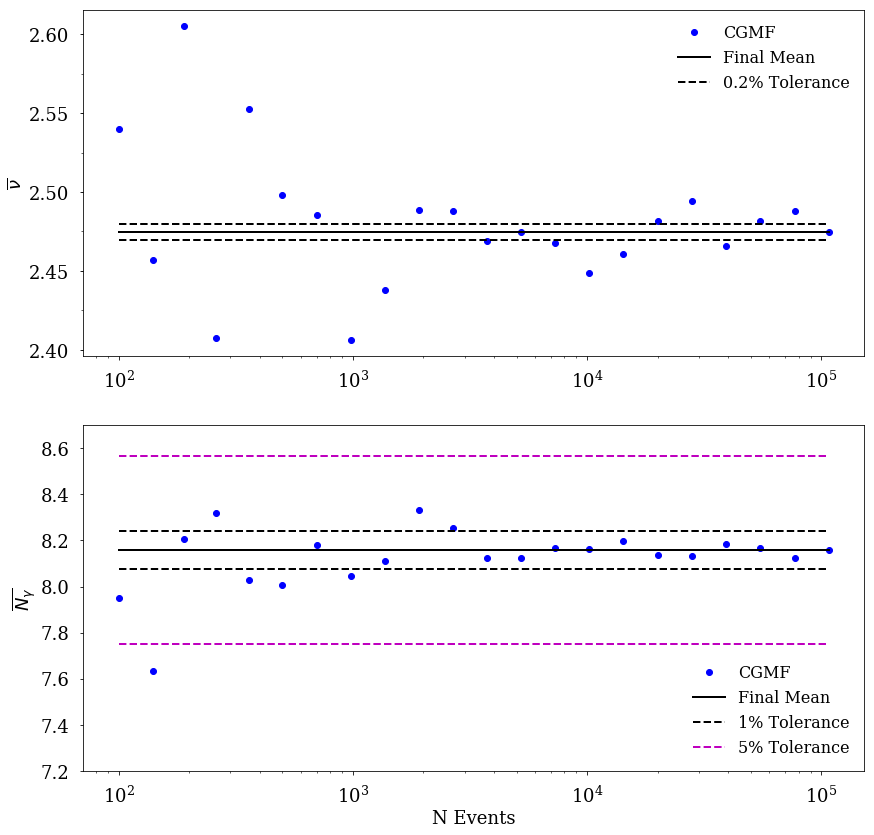

In [16]:
fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$\overline{\nu}$')
plt.semilogx(nhist_arr,nnt_mean, 'bo',label='CGMF')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [nnt_mean[nhist_arr.index(max(nhist_arr))], nnt_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
tolerance = 0.002
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))]], 'k--',label='0.2% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))]], 'k--')
lg = plt.legend(numpoints=1,fontsize=16)
lg.draw_frame(False)


plt.subplot(2,1,2)
plt.xlabel('N Events')
plt.ylabel(r'$\overline{N_{\gamma}}$')
plt.semilogx(nhist_arr,ngt_mean, 'bo',label='CGMF')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [ngt_mean[nhist_arr.index(max(nhist_arr))], ngt_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
tolerance = 0.01
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'k--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'k--')
tolerance = 0.05
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'm--',label='5% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'm--')
plt.ylim(7.2, 8.7)
lg = plt.legend(numpoints=1,fontsize=16,loc='lower right')
lg.draw_frame(False)

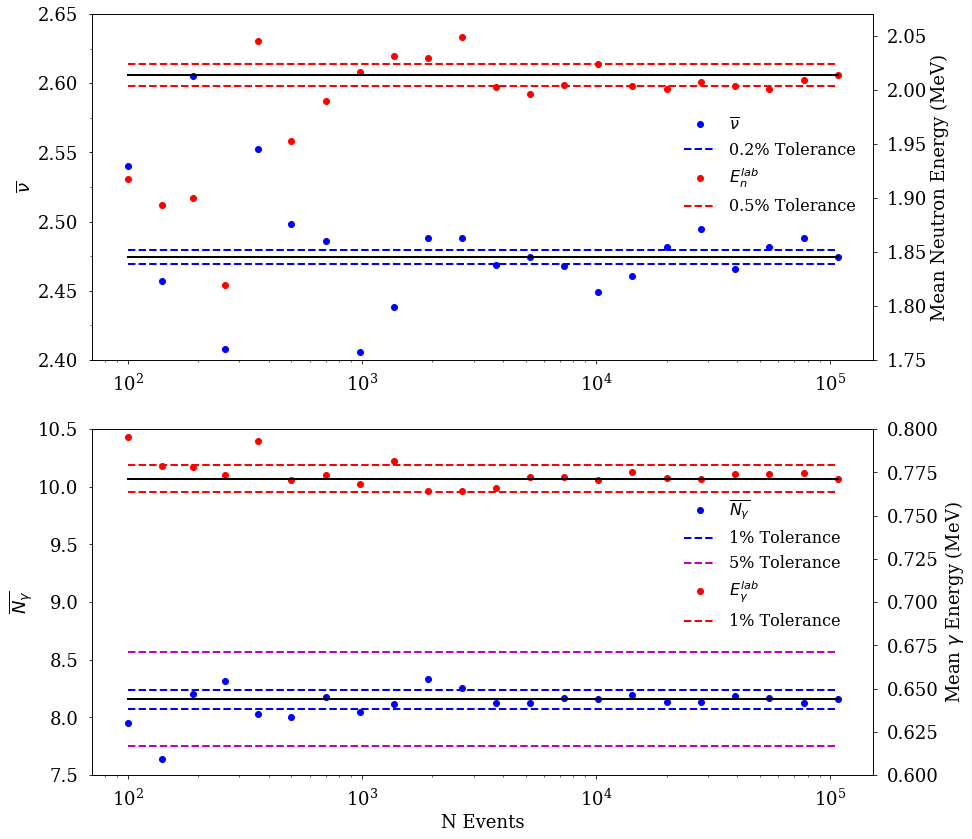

In [17]:
# Same plot as previous Cell, but with secondary axis and energies in lab frame

fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$\overline{\nu}$')
lns1 = plt.semilogx(nhist_arr,nnt_mean, 'bo',label=r'$\overline{\nu}$')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [nnt_mean[nhist_arr.index(max(nhist_arr))], nnt_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
tolerance = 0.002
lns2 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))]], 'b--',label='0.2% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*nnt_mean[nhist_arr.index(max(nhist_arr))]], 'b--')
plt.ylim(2.4, 2.65)

ax2 = ax1.twinx()
lns3 = ax2.semilogx(nhist_arr, Enlab_mean, 'ro',label=r'$E_{n}^{lab}$')
tolerance = 0.005
plt.semilogx([min(nhist_arr), max(nhist_arr)], [Enlab_mean[nhist_arr.index(max(nhist_arr))], Enlab_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
lns4 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*Enlab_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*Enlab_mean[nhist_arr.index(max(nhist_arr))]], 'r--',label='0.5% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*Enlab_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*Enlab_mean[nhist_arr.index(max(nhist_arr))]], 'r--')
ax2.set_ylabel('Mean Neutron Energy (MeV)')
plt.ylim(1.75, 2.07)


lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
lg = ax1.legend(lns, labs, loc=(0.75,0.4), numpoints=1,fontsize=16)
lg.draw_frame(False)


ax3 = plt.subplot(2,1,2)
plt.xlabel('N Events')
plt.ylabel(r'$\overline{N_{\gamma}}$')
lns1 = plt.semilogx(nhist_arr,ngt_mean, 'bo',label=r'$\overline{N_{\gamma}}$')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [ngt_mean[nhist_arr.index(max(nhist_arr))], ngt_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
tolerance = 0.01
lns2 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'b--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'b--')
tolerance = 0.05
lns3 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'm--',label='5% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ngt_mean[nhist_arr.index(max(nhist_arr))]], 'm--')
plt.ylim(7.5, 10.5)

ax4 = ax3.twinx()
lns4 = ax4.semilogx(nhist_arr, Eglab_mean, 'ro',label=r'$E_{\gamma}^{lab}$')
tolerance = 0.01
plt.semilogx([min(nhist_arr), max(nhist_arr)], [Eglab_mean[nhist_arr.index(max(nhist_arr))], Eglab_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
lns5 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*Eglab_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*Eglab_mean[nhist_arr.index(max(nhist_arr))]], 'r--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*Eglab_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*Eglab_mean[nhist_arr.index(max(nhist_arr))]], 'r--')
ax4.set_ylabel(r'Mean $\gamma$ Energy (MeV)')
plt.ylim(0.60, 0.8)

lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
lg = ax3.legend(lns, labs, loc=(0.75,0.4), numpoints=1,fontsize=16)
lg.draw_frame(False)

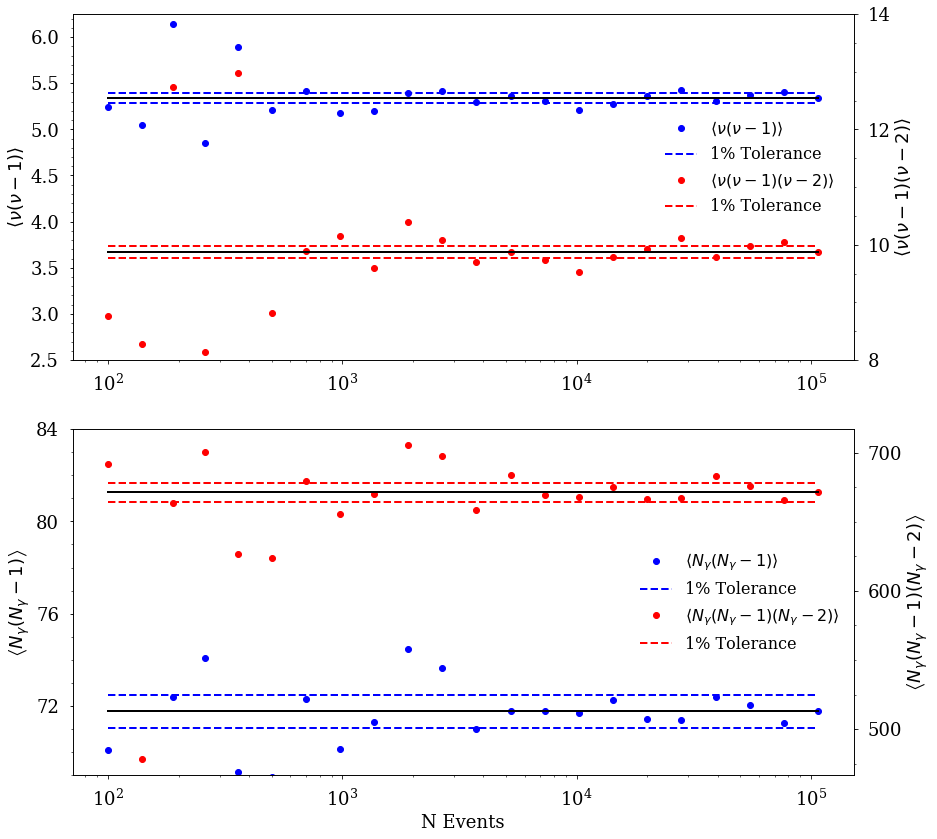

In [18]:
# Same plot as previous Cell, but with secondary axis and energies in lab frame

fig = plt.figure(figsize=(14,14))

ax1 = plt.subplot(2,1,1)
plt.ylabel(r'$\left \langle \nu(\nu-1) \right \rangle$')
lns1 = plt.semilogx(nhist_arr,nn2t_mean, 'bo',label=r'$\left \langle \nu(\nu-1) \right \rangle$')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [nn2t_mean[nhist_arr.index(max(nhist_arr))], nn2t_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
tolerance = 0.01
lns2 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*nn2t_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*nn2t_mean[nhist_arr.index(max(nhist_arr))]], 'b--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*nn2t_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*nn2t_mean[nhist_arr.index(max(nhist_arr))]], 'b--')
plt.ylim(2.5, 6.25)

ax2 = ax1.twinx()
lns3 = ax2.semilogx(nhist_arr, nn3t_mean, 'ro',label=r'$\left \langle \nu(\nu-1)(\nu-2) \right \rangle$')
tolerance = 0.01
plt.semilogx([min(nhist_arr), max(nhist_arr)], [nn3t_mean[nhist_arr.index(max(nhist_arr))], nn3t_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
lns4 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*nn3t_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*nn3t_mean[nhist_arr.index(max(nhist_arr))]], 'r--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*nn3t_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*nn3t_mean[nhist_arr.index(max(nhist_arr))]], 'r--')
ax2.set_ylabel(r'$\left \langle \nu(\nu-1)(\nu-2) \right \rangle$')
plt.ylim(8, 14)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
lg = ax1.legend(lns, labs, loc=(0.75,0.4), numpoints=1,fontsize=16)
lg.draw_frame(False)


ax3 = plt.subplot(2,1,2)
plt.xlabel('N Events')
plt.ylabel(r'$\left \langle N_{\gamma}(N_{\gamma}-1) \right \rangle$')
lns1 = plt.semilogx(nhist_arr,ng2t_mean, 'bo',label=r'$\left \langle N_{\gamma}(N_{\gamma}-1) \right \rangle$')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [ng2t_mean[nhist_arr.index(max(nhist_arr))], ng2t_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
tolerance = 0.01
lns2 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ng2t_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ng2t_mean[nhist_arr.index(max(nhist_arr))]], 'b--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ng2t_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ng2t_mean[nhist_arr.index(max(nhist_arr))]], 'b--')
plt.ylim(69, 84)
ax3.yaxis.set_major_locator(ticker.MultipleLocator(4))
ax3.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax4 = ax3.twinx()
lns3 = ax4.semilogx(nhist_arr, ng3t_mean, 'ro',label=r'$\left \langle N_{\gamma}(N_{\gamma}-1)(N_{\gamma}-2) \right \rangle$')
tolerance = 0.01
plt.semilogx([min(nhist_arr), max(nhist_arr)], [ng3t_mean[nhist_arr.index(max(nhist_arr))], ng3t_mean[nhist_arr.index(max(nhist_arr))]], 'k-',label='Final Mean')
lns4 = plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1+tolerance)*ng3t_mean[nhist_arr.index(max(nhist_arr))], (1+tolerance)*ng3t_mean[nhist_arr.index(max(nhist_arr))]], 'r--',label='1% Tolerance')
plt.semilogx([min(nhist_arr), max(nhist_arr)], [(1-tolerance)*ng3t_mean[nhist_arr.index(max(nhist_arr))], (1-tolerance)*ng3t_mean[nhist_arr.index(max(nhist_arr))]], 'r--')
ax4.set_ylabel(r'$\left \langle N_{\gamma}(N_{\gamma}-1)(N_{\gamma}-2) \right \rangle$')
#plt.ylim(850, 1300)
ax4.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax4.yaxis.set_minor_locator(ticker.MultipleLocator(25))

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
lg = ax3.legend(lns, labs, loc='center right', numpoints=1,fontsize=16)
lg.draw_frame(False)

[ -0.07480086  15.2619199 ]


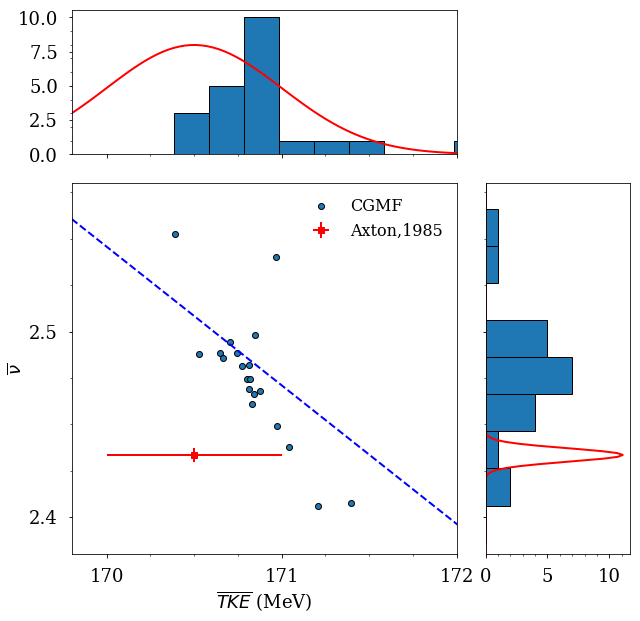

In [19]:
# Special Axis-Sharing Plot

fig, axScatter = plt.subplots(figsize=(10,10))

# the scatter plot:
sz = 8
axScatter.scatter(TKE_mean, nnt_mean, edgecolor='k',label="CGMF")
axScatter.set_aspect('auto')
axScatter.set_xlabel(r"$\overline{TKE}$ (MeV)")
axScatter.set_ylabel(r'$\overline{\nu}$')
axScatter.xaxis.set_major_locator(ticker.MultipleLocator(1))
axScatter.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))
axScatter.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
axScatter.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))

fit = np.polyfit(TKE_mean,nnt_mean,1)
print (fit)
fitfun = np.poly1d(fit)
x=np.linspace(169.8,173,100)
axScatter.plot(x,fitfun(x),'b--')
axScatter.errorbar(170.5,2.4334,xerr=0.5,yerr=0.0036,fmt='rs',label='Axton,1985') #-- experimental point
lg = plt.legend(numpoints=1,fontsize=16,loc='upper right')
lg.draw_frame(False)

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 2., pad=0.4, sharex=axScatter)
axHisty = divider.append_axes("right", 2., pad=0.4, sharey=axScatter)

# make some labels invisible
plt.setp(axHistx.get_xticklabels() + axHisty.get_yticklabels(),
         visible=False)

# now determine nice limits by hand:
xbinwidth = 0.2
ybinwidth = .02

xbins = np.arange(np.min(TKE_mean) - xbinwidth, np.max(TKE_mean) + xbinwidth, xbinwidth)
ybins = np.arange(np.min(nnt_mean) - ybinwidth, np.max(nnt_mean) + ybinwidth, ybinwidth)

axHistx.hist(TKE_mean, bins=xbins,edgecolor = 'k')
axHisty.hist(nnt_mean, bins=ybins, orientation='horizontal',edgecolor = 'k')

mean_TKE_exp = 170.5
sig_TKE_exp  = 0.5
axHistx.plot(x,10*mlab.normpdf(x, mean_TKE_exp, sig_TKE_exp), 'r')

mean_nu_exp  = 2.4334
sig_nu_exp   = 0.0036
y        = np.linspace(2,3,1000)
plt.plot(0.1*mlab.normpdf(y, mean_nu_exp, sig_nu_exp), y, 'r')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

#axHistx.axis["bottom"].major_ticklabels.set_visible(False)
for tl in axHistx.get_xticklabels():
    tl.set_visible(False)
axHistx.yaxis.set_major_locator(ticker.MultipleLocator(2.5))
axHistx.yaxis.set_minor_locator(ticker.MultipleLocator(1))

#axHisty.axis["left"].major_ticklabels.set_visible(False)
for tl in axHisty.get_yticklabels():
    tl.set_visible(False)
axHisty.xaxis.set_major_locator(ticker.MultipleLocator(5))
axHisty.xaxis.set_minor_locator(ticker.MultipleLocator(1))

axScatter.set_ylim([2.38,2.58])
axScatter.set_xlim([169.8,172])

plt.draw()
plt.show()